In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from typing import Optional, List, Tuple, Union

from cell_inference.config import params, paths
from cell_inference.cells.simulation import Simulation, Simulation_stochastic
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointconductance import PointConductance
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.transform.data_transform import log_modulus

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.dt = params.DT
h.steps_per_ms = 1/h.dt

h.tstop = 1000.

### Setup smiulation parameters

In [2]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_stochastic.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_passive.json' # passive dendrites
with open(filepath) as f:
    biophys_param = json.load(f)

In [3]:
biophys = [2.04, 0.0213, 0.0213, 0.693, 0.000261, 100., 100., 0.0000525, 0.000555, 0.0187]  # 2.04, 0.0639, 0.693 (1.0), 0.000261
# biophys = []
biophys_comm = {}

# interpret_params = False  # not using parameter interpreter
# geo_param = [135, 652, 163, 1.77, 1.26, .99] # 5 - 595 um
interpret_params = True  # using parameter interpreter
# geo_param = [1000, 1.]  # total length, radius scale
geo_param = [950., 0.142, 1., 0.59]  # total length 100-1200, prox prop 0.02-0.35, radius scale 0.4-1.5 (0.6-1.2), dist/prox radius 0.4-0.8 [950., 0.142, 1., 0.59]  

loc_param = [0., 0., 0., 0., 1., 0.] # position (x,y,z,alpha,h,phi)

In [4]:
ncell = 0
biophys_rep = np.tile(biophys,(ncell, 1)) 
# biophys_rep[:,5] = np.linspace(200, 300, ncell)
biophys = np.vstack((biophys_rep, biophys))
print(biophys)

[[2.04e+00 2.13e-02 2.13e-02 6.93e-01 2.61e-04 1.00e+02 1.00e+02 5.25e-05
  5.55e-04 1.87e-02]]


In [5]:
geo_param_rep = np.tile(geo_param,(ncell,1))
# geo_param_rep[:,6] = np.linspace(.1, .2, ncell)
# geo_param_rep[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.vstack((geo_param_rep, geo_param))
print(geo_param)

[[9.50e+02 1.42e-01 1.00e+00 5.90e-01]]


In [6]:
Len = {'p': 100 + 20, 'b': 100, 'a': 250}
# Len = {'p': 40 + 20, 'b': 160, 'a': 250}
# exc: apical / basal (#syn * PSC * FR * Prob / length)
print((7440 * 26 / Len['a']) / (4650 * 37 / Len['b']))
# inh: basal / apical
print((7440 * 0.72/ Len['a']) / (4650 * 0.3 / Len['b']))
# inh: sama / basal
print((256 * 162 * 17 * 0.88 / Len['p']) / (1023 * 24 * 4 * 0.72 / Len['b']))

0.44972972972972974
1.536
7.311827956989249


In [7]:
attr_kwargs = {}

# point_conductance_division = {'soma': [0], 'perisomatic': [1,2,4], 'basal': [3], 'apical': [7,8,9,10]}
# dens_params = {
#     'soma': {'g_e0': 0., 'g_i0': 15e-5, 'std_e': 1., 'std_i': 1.25},
#     'perisomatic': {'g_e0': 0., 'g_i0': 2e-5, 'std_e': 1., 'std_i': 1.25},
#     'basal': {'g_e0': 3e-5, 'g_i0': 1.5e-5, 'std_e': 3.4, 'std_i': 1.5},
#     'apical': {'g_e0': 1.35e-5, 'g_i0': 1e-5, 'std_e': 4., 'std_i': 3.}
# }
point_conductance_division = {'soma': [0], 'perisomatic': [1,4], 'basal': [2,3], 'apical': [7,8,9,10]}
dens_params = {
    'soma': {'g_e0': 0., 'g_i0': 15e-5, 'std_e': 1., 'std_i': 1.25},
    'perisomatic': {'g_e0': 0., 'g_i0': 4e-5, 'std_e': 1., 'std_i': 1.25},
    'basal': {'g_e0': 1.9e-5, 'g_i0': 2.45e-5, 'std_e': 3.4, 'std_i': 1.5},
    'apical': {'g_e0': 1.35e-5, 'g_i0': 1e-5, 'std_e': 4., 'std_i': 3.}
}
cnst_params = {'tau_e': 3., 'tau_i': 15.}

In [8]:
sim = Simulation_stochastic(
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = ncell + 1,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys,
    full_biophys = biophys_param,
    biophys_comm = biophys_comm,
    stim_param = {'start': 200.},
    interpret_params = interpret_params,
    interpret_type = 3,
    min_distance = params.MIN_DISTANCE,
    spike_threshold = params.SPIKE_THRESHOLD,
    cell_kwargs = {'attr_kwargs': attr_kwargs},
    point_conductance_division=point_conductance_division,
    dens_params=dens_params,
    cnst_params=cnst_params
)

cell = sim.cells[-1]
print(sim.geo_param)

[[134.9        652.08       163.02         1.7694       1.35910193
    1.043946  ]]


#### Add current injection

In [9]:
# # current injection in the tuft
# for sec_index in cell.grp_ids[5]:
#     cell.add_injection(sec_index=sec_index, pulse=True, record=True, amp=0.01, delay=0., dur=1e9)

#### Record membrane potential

In [10]:
V_rec = Recorder(cell.segments)

### Simulation results

In [11]:
sim.run_neuron_sim()

Vm = V_rec.as_numpy()

In [12]:
nspk, tspk = sim.get_spike_number(-1)
tspk = tspk[tspk > sim.stim_param['start']]
nspk = tspk.size
print('Spike count: %d' % (nspk))

Spike count: 8


#### Membrane voltage

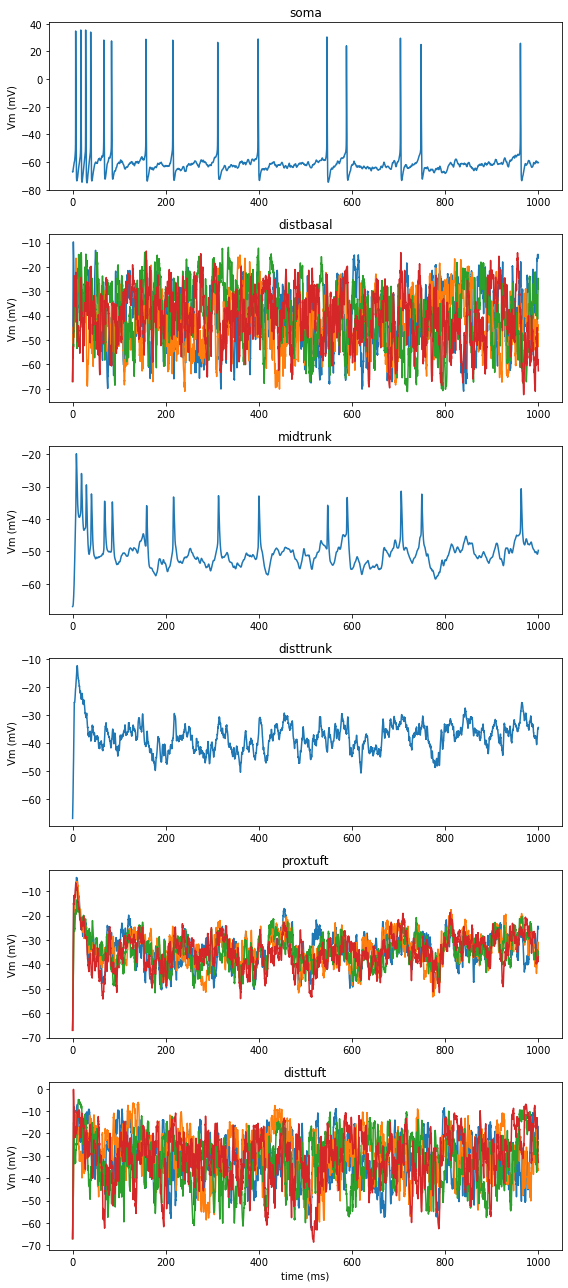

In [13]:
%matplotlib inline

plot_sec_type = [0, 3, 6, 7, 8, 10] # section type for plot membrane potential
loc = .5

n_type = len(plot_sec_type)
t = sim.t()
plt.figure(figsize=(8, 3 * n_type))
for i, type_id in enumerate(plot_sec_type):
    plt.subplot(n_type, 1, i + 1)
    for isec in cell.sec_id_lookup[type_id]:
        iseg = cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg)
        plt.plot(t, Vm[iseg, :])
    plt.ylabel('Vm (mV)')
    plt.title(cell.geometry.loc[type_id, 'name'])
plt.xlabel('time (ms)')
plt.tight_layout()
plt.show()

#### Calculate passive properties

In [14]:
for i in range(ncell):
    Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj)
    print((Vrest, Rin, Tau))

# (-67.28648876896166, 102.19853962576195, 15.849999999985585)  # [950., 0.142, 1., 0.59] geo_param
# (-67.94989081468924, 122.86662601811145, 15.724999999985698)  # [950., 0.142, 0.7, 0.8]
# (-66.68920003388767, 66.73068344994846, 18.599999999983083)  # [1200., 0.35, 1.5, 0.8]
# (-68.18723921905612, 171.26541594565055, 14.574999999986744)  # [100., 0.02, 0.4, 0.4]

#### Get segment coordinates for given cell and calculate electrotonic distance

In [15]:
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

19.577777324649244 0.0


In [16]:
%matplotlib inline

seg_coords = cell.seg_coords

tstart = sim.stim_param['start']
dur = 12
t = sim.t()
t_idx = (t>=tstart) & (t<=tstart+dur)
im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 20
max_per_dist = 1
space = 1.
normalized_space = True
sort_by_dist = True
figsize = (12, 9)
fontsize = 15
scalebar_size = 50

In [17]:
# _ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
#                                   distance_type='distance', n_dist=n_dist,
#                                   select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
#                                   space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
#                                   figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

In [18]:
# _ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
#                                   distance_type='elec_dist', n_dist=n_dist,
#                                   select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
#                                   space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
#                                   figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

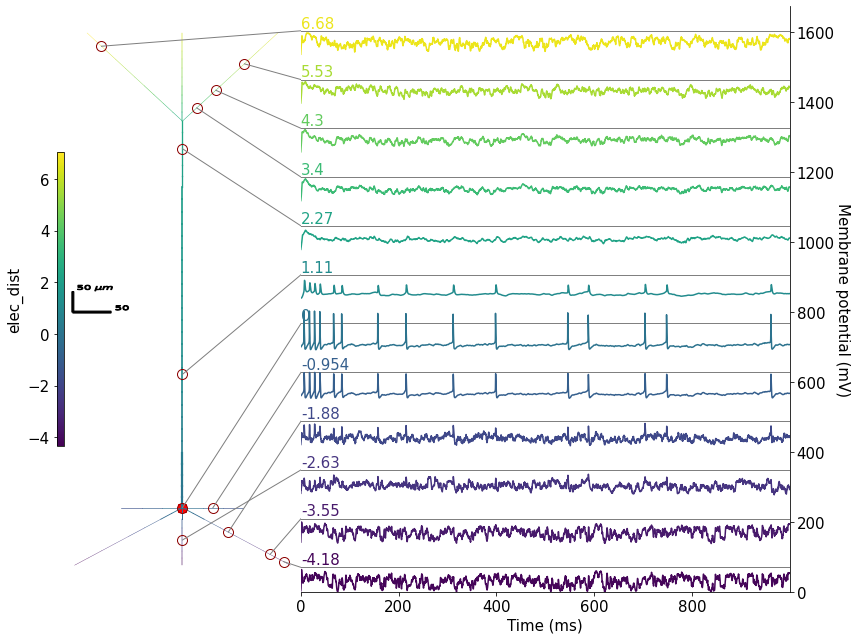

In [19]:
tstart = 0 # sim.stim.start
dur = h.tstop
t_idx = (t>=tstart) & (t<=tstart+dur)

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = Vm[:, t_idx]
varname = 'Membrane potential (mV)'
n_dist = 12
space = 2.
normalized_space = True
sort_by_dist = True

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

#### Plot LFP

In [20]:
loc_param = [0., 0., 80., 0., 1., np.pi*0/8]

if nspk == 0:
    raise ValueError('No spike.')
start_idx = int(np.ceil(sim.stim_param['start'] / h.dt)) # ignore signal before
end_idx = int(np.ceil(tspk[1] / h.dt)) if nspk > 1 else None
lfp = sim.lfp[-1].calc_ecp(move_cell=loc_param).T[slice(start_idx, end_idx),:]

output = process_lfp(lfp, y_window_size=params.Y_WINDOW_SIZE, ycoord=loc_param[1],
                     gauss_filt=True, calc_summ_stats=True, additional_stats=3)

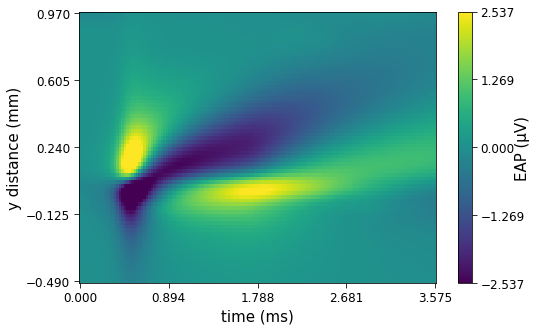

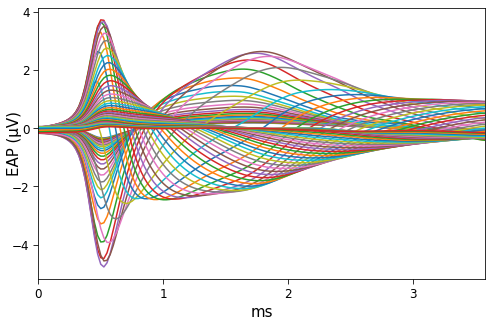

In [21]:
%matplotlib inline

ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

d = 1000 * output[1]  # mV -> uV
t = output[2]
coords = output[3]
x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]
ylim = [-500, 1100]
e_idx &= (coords[:, 1]>=ylim[0]) & (coords[:, 1]<=ylim[1])

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.ylabel('y distance (mm)')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, d[:, e_idx], #electrodes=coords[e_idx, :],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.show()

#### Check LFP at the tuft

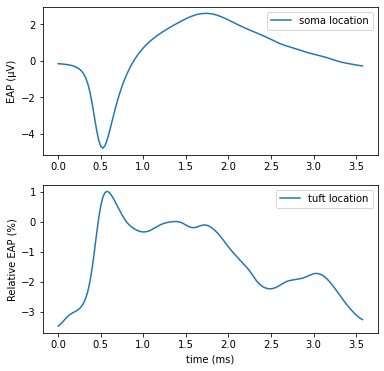

In [22]:
max_mag = np.amax(np.abs(d), axis=0)
max_mag_idx = np.argmax(max_mag, axis=0)
lfp_soma = d[:, max_mag_idx]
lfp_basal = d[:, e_idx][:, 0]
lfp_tuft = d[:, e_idx][:, -1]
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.plot(t, lfp_soma, label='soma location')
plt.ylabel('EAP (μV)')
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t, 100 * lfp_basal / max_mag[max_mag_idx], label='basal location')
plt.plot(t, 100 * lfp_tuft / max_mag[max_mag_idx], label='tuft location')
plt.ylabel('Relative EAP (%)')
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.show()

#### Check decay of LFP magnitude

In [23]:
%matplotlib inline

dy = ss2.DY
y2 = np.floor(ss2.NY / 2) * dy
grid_shape = (ss2.GRID_SHAPE[0], int(d.shape[1]/ss2.GRID_SHAPE[0]))
t_t, t_p, troughs, peaks = ss2.get_tr_pk(d)
y_troughs = ss2.get_max_val_y(troughs, grid_shape)
y_peaks = ss2.get_max_val_y(peaks, grid_shape)
lambda_troughs, pts_troughs, tr_max_idx = ss2.get_decay(y_troughs)
lambda_peaks, pts_peaks, pk_max_idx = ss2.get_decay(y_peaks)
tr_avg_mag, _ = ss2.volume_average(d, t_t, troughs, pts_troughs, tr_max_idx, grid_shape)
pk_avg_mag, _ = ss2.volume_average(d, t_p, peaks, pts_peaks, pk_max_idx, grid_shape)
# fit lines
l_troughs, brk_pts_trough = ss2.get_fit(y_troughs, pts_troughs)
l_peaks, brk_pts_peak = ss2.get_fit(y_peaks, pts_peaks)
pts_troughs = np.array(pts_troughs)
pts_peaks = np.array(pts_peaks)
pts_troughs[:, 2] *= dy
pts_peaks[:, 2] *= dy

np.set_printoptions(suppress=True)
print('Length constant (um) of troughs / peaks: \n  by lambda (left, right), by slope (left, right)')
print(dy * np.array([lambda_troughs, lambda_peaks]))
print('(w1, w2, y1) of two-line-segenmts (left, right) of troughs / peaks:')
print(pts_troughs)
print(pts_peaks)
print('(First, Second) slope of two-line-segenmts (left, right) of troughs / peaks:')
print(np.column_stack((pts_troughs[:, 0] / pts_troughs[:, 2], (pts_troughs[:, 1] - pts_troughs[:, 0]) / (y2 - pts_troughs[:, 2]))))
print(np.column_stack((pts_peaks[:, 0] / pts_peaks[:, 2], (pts_peaks[:, 1] - pts_peaks[:, 0]) / (y2 - pts_peaks[:, 2]))))
print('average lfp magnitude in the neighbor volume (t, x, y) near the break point relative to the global maximum:')
print(ss2.VOLUME_RANGE)
print('(left, right) of troughs / peaks:')
print(tr_avg_mag, pk_avg_mag )

Length constant (um) of troughs / peaks: 
  by lambda (left, right), by slope (left, right)
[[154.91317475 336.77617808 246.36493508 301.43660901]
 [219.8374726  219.79589585 254.10811121 143.79427827]]
(w1, w2, y1) of two-line-segenmts (left, right) of troughs / peaks:
[array([  2.36826199,   3.97783881, 366.8749833 ]), array([  1.37732654,   3.25109814, 463.85076692])]
[array([  3.23083553,   3.8566262 , 710.25871769]), array([  3.35538585,   6.81529204, 737.5000385 ])]
average lfp magnitude in the neighbor volume (t, x, y) near the break point relative to the global maximum:
[[[ -9   0 -14]
  [ 31   1   1]]

 [[ -9   0   0]
  [ 31   1  15]]]
(left, right) of troughs / peaks:
[-0.012193572851473362, -0.13439494118898784] [0.018507039343310872, 0.006209596408570191]


#### Apply log modulus transform to see small magnitude features

In [24]:
n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1
ref_mag = np.amax(np.abs(d)) / n_fold
print('Maximum magnitude is %d-fold reference magnitude %.3g μV.' % (n_fold, ref_mag))
lfp_logmod = log_modulus(d, ref_mag)

Maximum magnitude is 31-fold reference magnitude 0.154 μV.


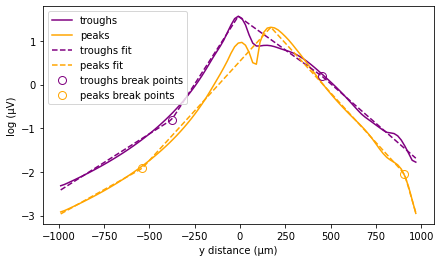

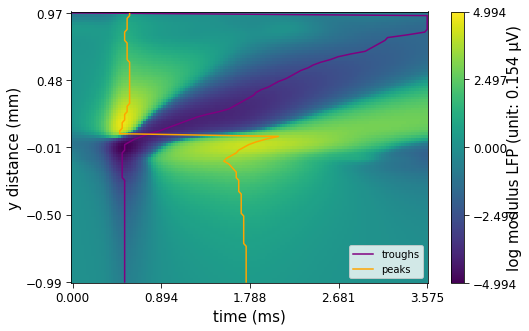

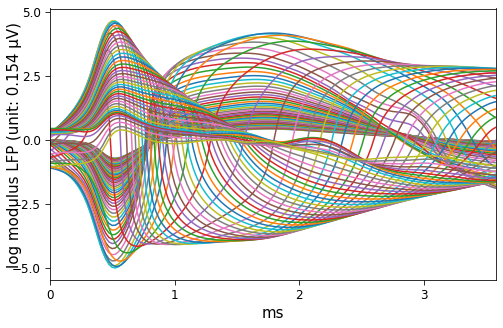

In [25]:
e_idx = coords[:, 0]==x_dist[ix]

def interp1(y, x):
    x = np.asarray(x)
    y = np.asarray(y)
    i = x.astype(int)
    return y[i] + (x - i) * (y[i + 1] - y[i])

plt.figure(figsize=(7, 4))
plt.plot(coords[e_idx, 1], np.log(y_troughs), color='purple', label='troughs')
plt.plot(coords[e_idx, 1], np.log(y_peaks), color='orange', label='peaks')
plt.plot(coords[e_idx, 1], l_troughs, color='purple', linestyle='--', label='troughs fit')
plt.plot(coords[e_idx, 1], l_peaks, color='orange', linestyle='--', label='peaks fit')
plt.plot(interp1(coords[e_idx, 1], brk_pts_trough[0]), brk_pts_trough[1], color='purple',
         linestyle='none', marker='o', markerfacecolor='none', markersize=8, label='troughs break points')
plt.plot(interp1(coords[e_idx, 1], brk_pts_peak[0]), brk_pts_peak[1], color='orange',
         linestyle='none', marker='o', markerfacecolor='none', markersize=8, label='peaks break points')
plt.xlabel('y distance (μm)')
plt.ylabel('log (μV)')
plt.legend()

lfp_label = 'log modulus LFP (unit: %.3g μV)' % (ref_mag)

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp_logmod[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='max', colorbar_label=lfp_label, axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()
plt.ylabel('y distance (mm)')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_logmod[:, e_idx], # electrodes=coords[e_idx, :], vlim='max',
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel(lfp_label)

plt.show()

#### Plot morphology

<IPython.core.display.Javascript object>


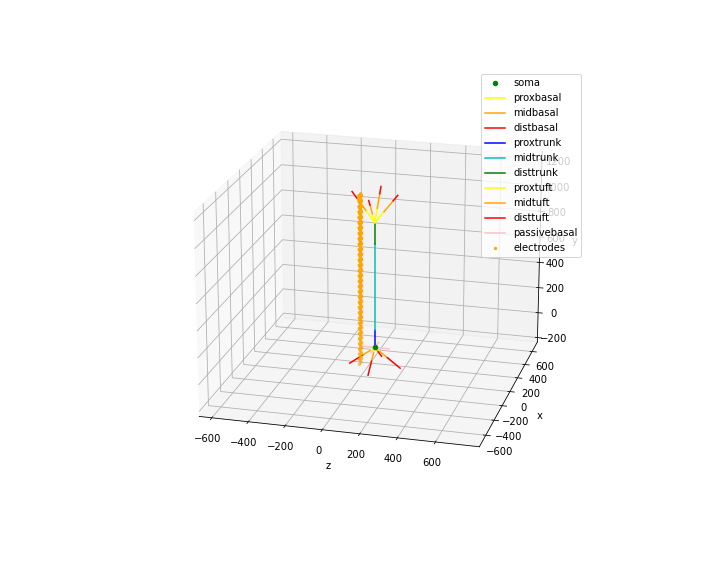

In [26]:
%matplotlib notebook

_ = plot_morphology(sim, ncell, electrodes=params.ELECTRODE_POSITION, move_cell=loc_param,
                    elev=20, azim=-75, figsize=(10, 8),
                    clr = ['g',       #soma
                           'yellow',  #proxbasal
                           'orange',  #midbasal
                           'red',     #distbasal
                           'b',  #proxtrunk
                           'c',    #midtrunk
                           'g',   #disttrunk
                           'yellow',  #proxtuft
                           'orange',  #midtuft
                           'red',     #disttuft
                           'pink',       #axon
                           'purple']   #passivebasal
                   )